# StyleGAN2 + CLIP (StyleGAN-NADA) — Inference Only

**Purpose:** Load a trained generator and generate samples. No training.

**How to use:** To view generations for **both versions (v1, v2)** and **different epochs** (50, 100, 150, 200, …): set **VERSION** and **EPOCH** in the cells below, paste the checkpoints root folder link, then **Run All**. To switch to another version or epoch, change VERSION and/or EPOCH and **Run All** again — already downloaded checkpoints are **not re-downloaded**; only the new one is fetched if needed.

**Flow:** One link to the checkpoints root on Drive. We list the structure and download only the file for the chosen VERSION/EPOCH. Local layout: `checkpoints/1/50/checkpoint_50.pt`, `checkpoints/2/200/checkpoint_200.pt`, etc. StyleGAN2 code from GitHub.

## User settings

Choose **VERSION** and **EPOCH** of the checkpoint to load. Epochs: 50, 100, 150, 200, 250, 300, 350, 400, 450, 500.

In [34]:
VERSION = "1"   # 1, 2
EPOCH = 200     # 50, 100, 150, 200, 250, 300, 350, 400, 450, 500

## Step 1: Checkpoint folder + download

Paste a **folder link** per (version, epoch). Only the link for the chosen VERSION and EPOCH is used. Use Google Drive “Get link” → “Anyone with the link” and paste the link or the `https://drive.google.com/uc?id=FILE_ID` URL. If the checkpoint is already on disk, download is skipped.

In [35]:
# One link to the entire checkpoints root folder. gdown lists structure (skip_download) and we download only the file for chosen VERSION/EPOCH.
CHECKPOINT_ROOT_FOLDER_LINK = "https://drive.google.com/drive/folders/1-GKs8Zw0Zd8TnIhy_QLPXNH0S1D6TKdR?usp=sharing"


In [36]:
import os

WORK_DIR = "/content" if os.path.exists("/content") else "."
CHECKPOINTS_ROOT = os.path.join(WORK_DIR, "checkpoints")
REPOS_DIR = os.path.join(WORK_DIR, "repos")
CHECKPOINT_NAME = f"checkpoint_{EPOCH}.pt"
OUTPUT_DIR = os.path.join(WORK_DIR, "output")
os.makedirs(OUTPUT_DIR, exist_ok=True)

version_dir = os.path.join(CHECKPOINTS_ROOT, VERSION)
epoch_dir = os.path.join(version_dir, str(EPOCH))
CKPT_PATH = os.path.join(epoch_dir, CHECKPOINT_NAME)
need_download = not os.path.isfile(CKPT_PATH)

if not isinstance(CHECKPOINT_ROOT_FOLDER_LINK, str) or not CHECKPOINT_ROOT_FOLDER_LINK.strip() or "/folders/" not in CHECKPOINT_ROOT_FOLDER_LINK:
    raise ValueError("Set CHECKPOINT_ROOT_FOLDER_LINK in the cell above (Google Drive folder link, Anyone with the link).")
root_url = CHECKPOINT_ROOT_FOLDER_LINK.strip()

if need_download:
    import gdown
    print("Listing root folder structure (skip_download)...")
    files_list = gdown.download_folder(url=root_url, skip_download=True, quiet=False)
    if not files_list:
        raise RuntimeError("Could not retrieve folder structure. Check root link and sharing (Anyone with the link).")
    target_path = f"{VERSION}/{EPOCH}/{CHECKPOINT_NAME}"
    item = next((f for f in files_list if f.path == target_path or f.path.replace(chr(92), "/").endswith(f"{EPOCH}/{CHECKPOINT_NAME}") or (f"{VERSION}/{EPOCH}/" in f.path.replace(chr(92), "/") and CHECKPOINT_NAME in f.path)), None)
    if not item:
        raise FileNotFoundError(f"{CHECKPOINT_NAME} not found at {target_path} in root. Check VERSION/EPOCH and root folder structure.")
    os.makedirs(epoch_dir, exist_ok=True)
    print("Downloading", CHECKPOINT_NAME, "...")
    gdown.download(id=item.id, output=CKPT_PATH, quiet=False)
    print("Saved to", CKPT_PATH)
else:
    print("Checkpoint already on disk:", CKPT_PATH)

CHECKPOINTS_DIR = epoch_dir
if os.path.isdir(CHECKPOINTS_DIR):
    print("Available:", sorted([f for f in os.listdir(CHECKPOINTS_DIR) if f.endswith(".pt")]) or "(none)")
print("Using:", CKPT_PATH)

Checkpoint already on disk: /content/checkpoints/1/200/checkpoint_200.pt
Available: ['checkpoint_200.pt']
Using: /content/checkpoints/1/200/checkpoint_200.pt


## Step 2: Install deps and StyleGAN2 repo (GitHub)

Clone StyleGAN2 repo from GitHub if not already present. No Drive, no CLIP, no base weights.

In [37]:
!pip install -q ftfy regex tqdm gdown Ninja

In [38]:
import torch
import sys
import random
import numpy as np

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"CUDA: {torch.cuda.is_available()}")
print(f"GPU: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'none'}")

CUDA: True
GPU: Tesla T4


In [39]:
SEED = 3456
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
print(f"Seeds fixed to {SEED}.")

Seeds fixed to 3456.


In [40]:
# StyleGAN2 repo
STYLEGAN2_ROOT = os.path.join(REPOS_DIR, "stylegan2-pytorch")
if not os.path.isfile(os.path.join(STYLEGAN2_ROOT, "model.py")):
    os.makedirs(REPOS_DIR, exist_ok=True)
    print("Cloning StyleGAN2 repo...")
    !git clone https://github.com/rosinality/stylegan2-pytorch.git "{STYLEGAN2_ROOT}"
else:
    print("StyleGAN2 repo at", STYLEGAN2_ROOT)
sys.path.insert(0, STYLEGAN2_ROOT)

StyleGAN2 repo at /content/repos/stylegan2-pytorch


In [41]:
# Inference needs only checkpoint (G_train). No base weights, no CLIP.

## Step 3: Load trained generator

Create Generator, load trained weights from checkpoint (key `G_train`). Checkpoint contains full trained generator.

In [42]:
from model import Generator

latent_dim = 512
generator = Generator(size=1024, style_dim=latent_dim, n_mlp=8).to(device)

if not os.path.isfile(CKPT_PATH):
    raise FileNotFoundError(f"Checkpoint not found: {CKPT_PATH}. Set VERSION and EPOCH in User settings, then run Step 1 to download.")
with open(CKPT_PATH, "rb") as f:
    if f.read(100).lstrip().startswith(b"<"):
        raise RuntimeError(
            f"{CKPT_PATH} is an HTML file (Drive returned a page, not the .pt). "
            "Re-run Step 1 with a direct download link (https://drive.google.com/uc?id=FILE_ID), or download the .pt manually."
        )
ckpt = torch.load(CKPT_PATH, map_location=device, weights_only=False)
generator.load_state_dict(ckpt["G_train"])
generator.eval()

print("Trained generator loaded from", CKPT_PATH)
if "source" in ckpt and "target" in ckpt:
    print("  source:", ckpt.get("source", "—"))
    print("  target:", ckpt.get("target", "—"))
    print("  iter:", ckpt.get("iter", "—"))

Trained generator loaded from /content/checkpoints/1/200/checkpoint_200.pt
  source: a photo of a face
  target: a drawn anime style face
  iter: 200


## Step 4: Generate samples

Sample random z, generate images with the trained generator, display.

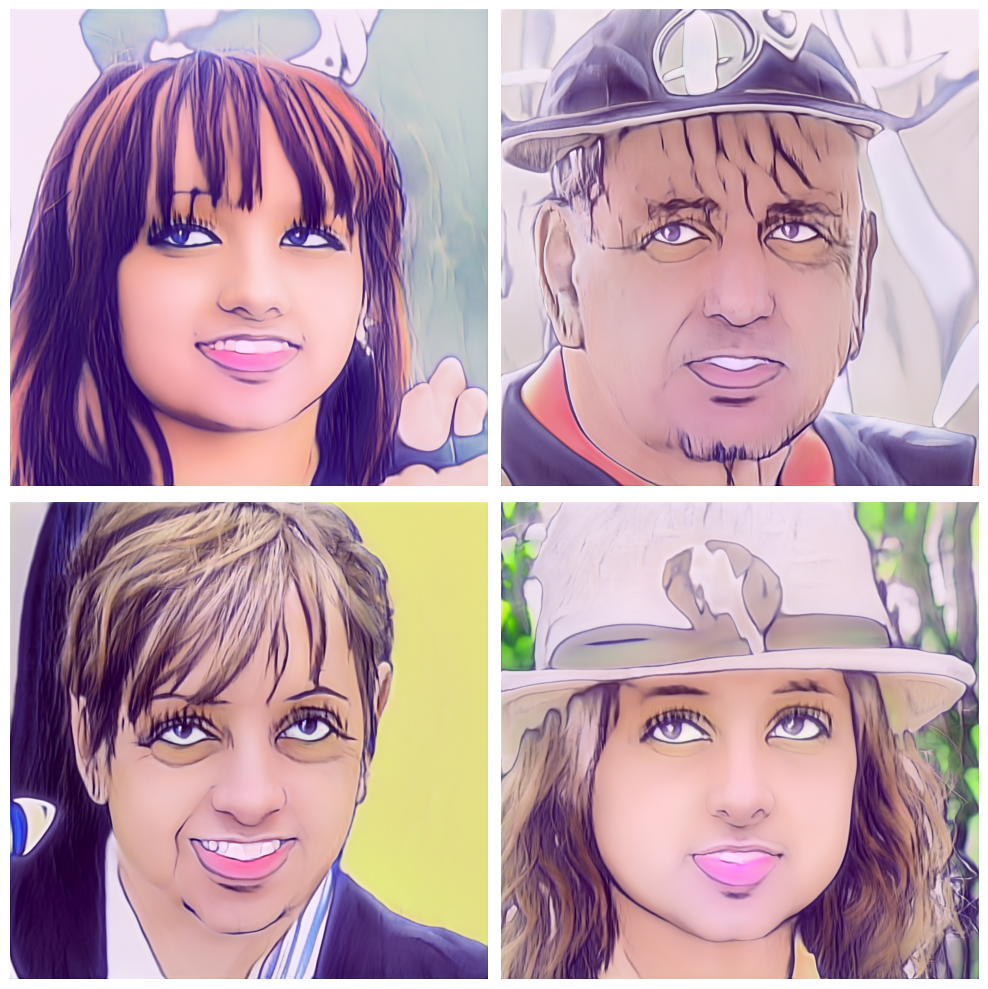

In [43]:
import matplotlib.pyplot as plt

def to_np(tensor):
    """Convert (B, 3, H, W) tensor in [-1,1] to numpy for display."""
    x = (tensor.clamp(-1, 1) + 1) / 2
    x = x.permute(0, 2, 3, 1).cpu().numpy()
    return x

N_SAMPLES = 4  # number of images to generate

with torch.no_grad():
    z = torch.randn(N_SAMPLES, latent_dim, device=device)
    imgs, _ = generator([z], input_is_latent=False)

imgs_np = to_np(imgs)

fig, axes = plt.subplots(2, 2, figsize=(10, 10))
axes = axes.flatten()
for i in range(N_SAMPLES):
    axes[i].imshow(imgs_np[i])
    axes[i].axis("off")
plt.tight_layout()
plt.show()

In [44]:
# Optional: save generated images
from PIL import Image

ckpt_basename = os.path.splitext(os.path.basename(CKPT_PATH))[0]
for i in range(N_SAMPLES):
    arr = (imgs_np[i] * 255).astype(np.uint8)
    img = Image.fromarray(arr)
    out_path = os.path.join(OUTPUT_DIR, f"{ckpt_basename}_sample_{i}.png")
    img.save(out_path)
    print("Saved:", out_path)

Saved: /content/output/checkpoint_200_sample_0.png
Saved: /content/output/checkpoint_200_sample_1.png
Saved: /content/output/checkpoint_200_sample_2.png
Saved: /content/output/checkpoint_200_sample_3.png
